# Calculate and plot the number of exchanged messages over time

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Global variables

In [13]:
pd.set_option("display.precision", 10)
pd.set_option('display.max_rows', 500)

timeframe_upper_limit = 60 # Seconds after startup that you want to look at

### Add path to the dict, use number of nodes as key
It will:
- collect all runs 
- use the key as groupby-column

In [14]:
paths =	{
  # "111": "../../logs/maintenance/25-03-2021",
  "73": "../../logs/maintenance/29-03-2021"
}

exclude_paths = ["faulty"]

num_nodes = 73
height = 2
degree = 8

num_runs = {
  73: 3,
  111: 5
}

In [15]:
# m_xxx = maintenance_xxx
# d_xxx = data_xxx
m_stamps = []
m_topologies = []
m_node_ids = []
m_runs = []
m_connect_outliers = []

d_stamps = []
d_topologies = []
d_node_ids = []
d_runs = []

startup_times = {}

for path in paths : 
    #print(path)
    for root, dirs, files in os.walk(paths[path]) :
        dirs[:] = [directory for directory in dirs if directory not in exclude_paths]
        # print(root)
        # print(dirs)
        # print(files)
        run = root.split('_')[-1]
        for file in files :
            with open( os.path.join(root, file) ) as log :   
                connect_attempts = 0
                node_id = file.split('_')[0][4:]              
                for line in log :            
                    if "RECEIVED MESSAGE" in line:
                        # maintencance messages 
                        elem = line.split( )                
                        m_node_ids.append(int(node_id))                        
                        m_stamps.append( int(elem[8]) ) # unix timestamp
                        m_topologies.append( int(path) )
                        m_runs.append(int(run))
                    elif "DATA RECEIVED" in line:
                        # data messages
                        pass
                    elif "STARTUP TIME" in line:
                        elem = line.split( )
                        startup_times[int(run)] = int(elem[-1])
                    elif "Try to connect" in line:
                        connect_attempts += 1
                
                if (connect_attempts > 5):
                    m_connect_outliers.append("run " + run + " node " + node_id)

m_data = pd.DataFrame(np.column_stack([m_topologies, m_runs, m_node_ids, m_stamps]), columns=['topology', 'run', 'node_id', 'timestamp'])
# print(startup_time)
# m_data

In [16]:
m_data['timestamp'] = m_data.apply(lambda row: row.timestamp - startup_times[row.run], axis=1)
m_data['timestamp_sec'] = m_data['timestamp'].apply(lambda x: x // 1000000000)
# m_data

# Reduce timeframe

In [17]:
m_data = m_data[m_data.timestamp_sec <= timeframe_upper_limit]
m_data

,topology,run,node_id,timestamp,timestamp_sec
0,73,2,39,3328236936,3
1,73,2,39,3328611898,3
2,73,2,39,3328752528,3
3,73,2,39,3328779430,3
4,73,2,39,3331840842,3
...,...,...,...,...,...
12626,73,1,28,49897246904,49
12627,73,1,28,49897277860,49
12628,73,1,28,57302341753,57
12629,73,1,28,57902356291,57


# Try to find outliers

In [18]:
m_outliers = m_data.groupby(['topology', 'run', 'node_id', 'timestamp_sec']).size().reset_index(name='number of messages').sort_values(by=['number of messages'], ascending=False, axis=0)
#m_outliers.head()

# Compute results

In [19]:
m_grouped = m_data.groupby(['topology', 'timestamp_sec']).size().reset_index(name='number of messages')
m_grouped['number of messages'] = m_grouped.apply(lambda row: row['number of messages'] / num_runs[row['topology']], axis=1)
m_grouped['number of messages per node'] = m_grouped.apply(lambda row: row['number of messages'] / row['topology'], axis=1)
# m_grouped

# Plot

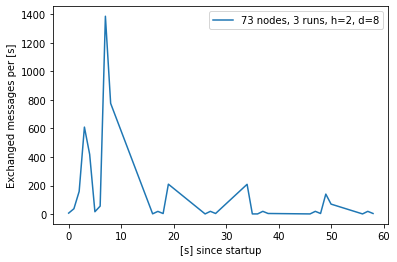

In [20]:
ax = plt.gca()

m_grouped.plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Exchanged messages per [s]")

plt.legend([str(num_nodes) +' nodes, ' + str(num_runs[num_nodes]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=10
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
plt.savefig('maintenance-paper.pdf')  

In [21]:
first_30 = m_grouped[m_grouped['timestamp_sec'] <= 30]['number of messages'].sum()
first_60 = m_grouped[m_grouped['timestamp_sec'] <= 60]['number of messages'].sum()

print('Overall exchanged maintenance messages within first 30s: ' + str(first_30))
print('Overall exchanged maintenance messages within first 60s: ' + str(first_60))

print('\nOverall exchanged maintenance messages during first 30s per node: ' + str(first_30 / num_nodes - 9))

print('Overall exchanged messages during first 60s per second: ' + str(first_60/(60)))
print('Overall exchanged messages during first 60s per node: ' + str(first_60/(64)))
print('Overall exchanged messages during first 60s per second per node: ' + str(first_60/(60*64)))

Overall exchanged maintenance messages within first 30s: 3719.6666666666665
Overall exchanged maintenance messages within first 60s: 4210.333333333334

Overall exchanged maintenance messages during first 30s per node: 41.954337899543376
Overall exchanged messages during first 60s per second: 70.17222222222223
Overall exchanged messages during first 60s per node: 65.78645833333334
Overall exchanged messages during first 60s per second per node: 1.0964409722222224


In [22]:
# For comparision with movement scenario 
begin = m_grouped[(m_grouped['timestamp_sec'] >= 31) & (m_grouped['timestamp_sec'] <= 41)]['number of messages'].sum()

print('Messages exchanged between 31s,41s: ' + str(begin))
print('Messages exchanged between 31s,41s per node: ' + str(begin/64))

Messages exchanged between 31s,41s: 233.33333333333334
Messages exchanged between 31s,41s per node: 3.6458333333333335
